# Question 3: Be Zillow, But Better?

In class, we discussed the neural networks don't tend to outperform tree based models when the input data is tabular in structure.  While this is generally true, one situation with tabular data where a neural network can make developing a predictive model less cumbersome is when the data set contains **lots** of categorical variables.  In this problem, you'll be working with a novel housing data set and attempting to build a model that predicts the sale price for homes based on a variety of input features.

The data set `house_train.csv` contains 943 instances of houses that sold in Sacremento, CA between 2007 and 2010.  The sale price for each home is contained in the column `SalePrice`. `house_valid.csv` contains 254 instances with the sale price included.  `house_test_noval.csv` is a test set with 254 more instances, but no sale price.  Each instance is associated with 63 features that relate to the size of the home, recency of the build, neighborhood, etc:

In [35]:
import pandas as pd
import numpy as np

In [36]:
# Read the CSV file
train_df = pd.read_csv('/Users/nicholasrichards/Desktop/machine_learning_2/ProblemSet2/house_train.csv')
val_df = pd.read_csv('/Users/nicholasrichards/Desktop/machine_learning_2/ProblemSet2/house_valid.csv')
test_df = pd.read_csv('/Users/nicholasrichards/Desktop/machine_learning_2/ProblemSet2/house_test_noval.csv')

# Display the head of all columns
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed
print(train_df.head())

   MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0          20       RL     9600   Pave      Reg         Lvl    AllPub   
1          50       RL    14115   Pave      IR1         Lvl    AllPub   
2          20       RL    10084   Pave      Reg         Lvl    AllPub   
3          60       RL    10382   Pave      IR1         Lvl    AllPub   
4          50       RM     6120   Pave      Reg         Lvl    AllPub   

  LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
1    Inside       Gtl      Mitchel       Norm       Norm     1Fam     1.5Fin   
2    Inside       Gtl      Somerst       Norm       Norm     1Fam     1Story   
3    Corner       Gtl       NWAmes       PosN       Norm     1Fam     2Story   
4    Inside       Gtl      OldTown     Artery       Norm     1Fam     1.5Fin   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0    

The main challenge with this data set is that the vast majority of the features are **categorical** and must be encoded to use them in various regression style models.  Identifying the categorical features is a little challenging here since there are so many.  Here, any variables about Area, Square Footage (SF), or Porch (annoyingly not containing SF or Area) are continuous measurements.  All other columns should be treated as categorical.

**Note**: The training data was constructed as a subset of a larger data set in a way that ensures that each category for each categorical variable is included in the training data set at least once.  This means that there won't be any previously unseen categories in the validation and test data!  Please use this exact training data set when training your models to avoid running into prediction problems.

In [37]:
# Create lists of continuous and categorical column names
continuous_x = [col for col in train_df.columns if any(substring in col.lower() for substring in ["area", "sf", "porch", "saleprice"])]

cat_x = [col for col in train_df.columns if col not in continuous_x]

continuous_x.remove('SalePrice')

print(continuous_x)
print(f"There are {len(continuous_x)} continuous variables.")

print(cat_x)
print(f"There are {len(cat_x)} categorical variables.")

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
There are 17 continuous variables.
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'PavedDrive', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
There are 46 categorical variables.


The most common method of dealing with categorical variables is to one-hot encode them.  However, this will lead to a *very large* feature set relative to the number of observations.

In [38]:
# Print the total number of distinct values for each variable in cat_x
distinct_values = {col: train_df[col].nunique() for col in cat_x}
print(distinct_values)

# Calculate the total number of dummies needed for a regression model
total_dummies = sum(train_df[col].nunique() for col in cat_x)
print(f"Total number of categories: {total_dummies}")

{'MSSubClass': 15, 'MSZoning': 5, 'Street': 2, 'LotShape': 4, 'LandContour': 4, 'Utilities': 2, 'LotConfig': 5, 'LandSlope': 3, 'Neighborhood': 25, 'Condition1': 9, 'Condition2': 8, 'BldgType': 5, 'HouseStyle': 8, 'OverallQual': 10, 'OverallCond': 9, 'YearBuilt': 112, 'YearRemodAdd': 61, 'RoofStyle': 6, 'RoofMatl': 8, 'Exterior1st': 15, 'Exterior2nd': 16, 'MasVnrType': 3, 'ExterQual': 4, 'ExterCond': 5, 'Foundation': 6, 'Heating': 6, 'HeatingQC': 5, 'CentralAir': 2, 'Electrical': 5, 'BsmtFullBath': 4, 'BsmtHalfBath': 3, 'FullBath': 4, 'HalfBath': 3, 'BedroomAbvGr': 8, 'KitchenAbvGr': 4, 'KitchenQual': 4, 'TotRmsAbvGrd': 12, 'Functional': 7, 'Fireplaces': 4, 'GarageCars': 5, 'PavedDrive': 3, 'MiscVal': 21, 'MoSold': 12, 'YrSold': 5, 'SaleType': 9, 'SaleCondition': 6}
Total number of categories: 482


Additionally, house prices follow a power distribution and a standard loss function like MSE will overrespond to big misses on high priced homes that have more to do with neighborhood effects than house features.

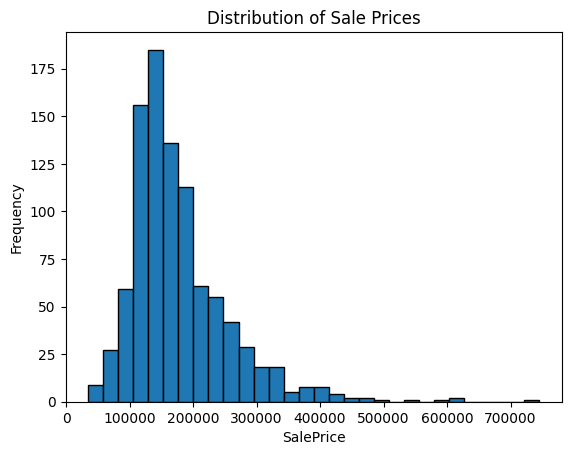

In [39]:
import matplotlib.pyplot as plt

# Create a histogram of y_train
plt.hist(train_df['SalePrice'], bins=30, edgecolor='black')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Prices')
plt.show()

While it is possible to change the MSE loss function to a more *robust* one (e.g. Huber loss) or deal with large categorical feature sets (CatBoost) in the tree framework, neural networks are much more suited for making these changes through their differentiable backpropogation framework.  Using PyTorch, changing the loss function is as simple as changing the loss function in your PyTorch module!  Additionally, categorical feature spaces can be easily dealt with using an **embeddings** framework.

For this question, you'll build models that attempt to best predict the house price for the houses included in the test data set.

## Data Preprocessing: Standardization and Encoding

For the purposes of machine learning, features are typically assumed to be either continuous or categorical.  It is possible to deal with ordered categorical variables in a different way, but most of the time, they are treated as unordered categorical variables.

As we saw in class, one way to prevent exploding and vanishing gradients is to ensure that any continuous variables are demeaned and scaled to have unit variance.  Since we aren't concerned with interpreting any coefficients, removing this scale is completely okay.

When we're working with training data to develop models that will be used to create predictions for new data, we need to be careful how we center and scale columns.  Specifically, we need to be sure that we're storing the mean and variance of each column in the training data so that the same transformation can be done to any feature vectors that will be used to create predictions later.

Additionally, we're going to scale the outcome variable to better facilitate weights close to zero and avoid gradient problems.

Similarly, categorical variables need to be encoded using integer labels since there isn't really a way to enter character strings in a matrix.  How we choose to do this encoding needs to be based on the training data and the logic for how these category values are mapped to integers also needs to be cosnsistently applied to create a prediction pipeline.

Fortunately, `sklearn` provides a streamlined way to do this!  Given some indication of which variables are continuous and which variables are categorical, we can develop a data pre-processing pipeline that can be consistently applied to any new feature vector that has the same organization. 


In [40]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Initialize the scaler and encoders
scaler = StandardScaler()
price_scaler = StandardScaler()
encoders = {col: LabelEncoder() for col in cat_x}

# Fit the scaler on the continuous features of the training data
train_df[continuous_x] = scaler.fit_transform(train_df[continuous_x])

# Scale 'SalePrice' separately if it is in the data
if 'SalePrice' in train_df.columns:
    train_df['SalePrice'] = price_scaler.fit_transform(train_df[['SalePrice']])

# Fit the encoders on the categorical features of the training data
for col in cat_x:
    train_df[col] = encoders[col].fit_transform(train_df[col])

# Apply the same transformations to the validation and test data
val_df[continuous_x] = scaler.transform(val_df[continuous_x])
test_df[continuous_x] = scaler.transform(test_df[continuous_x])

if 'SalePrice' in val_df.columns:
    val_df['SalePrice'] = price_scaler.transform(val_df[['SalePrice']])
if 'SalePrice' in test_df.columns:
    test_df['SalePrice'] = price_scaler.transform(test_df[['SalePrice']])

for col in cat_x:
    val_df[col] = encoders[col].transform(val_df[col])
    test_df[col] = encoders[col].transform(test_df[col])

# Display the transformed dataframes
print(train_df.head())

   MSSubClass  MSZoning   LotArea  Street  LotShape  LandContour  Utilities  \
0           0         3 -0.104724       1         3            3          0   
1           4         3  0.358146       1         0            3          0   
2           0         3 -0.055105       1         3            3          0   
3           5         3 -0.024555       1         0            3          0   
4           4         4 -0.461488       1         3            3          0   

   LotConfig  LandSlope  Neighborhood  Condition1  Condition2  BldgType  \
0          2          0            24           1           2         0   
1          4          0            11           2           2         0   
2          4          0            21           2           2         0   
3          0          0            14           4           2         0   
4          4          0            17           0           2         0   

   HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  RoofStyl

Now that the data sets are standardized and encoded, we have to choose some way to numerically represent the fact that integer encoding labels are arbitrary representations of a categorical variable.

When dealing with categorical variables, the conventional approach is to use **one‑hot encoding**. In one‑hot encoding, each category is represented as a vector whose length is equal to the total number of categories, with a single element set to 1 (indicating the presence of that category) and all other elements set to 0. Mathematically, if a categorical variable can take on one of $C$ values, a particular category $i$ is represented by the vector: 

$$\mathbf{e}_i = \left[0, \ldots, 0, \underset{\text{position } i}{1}, 0, \ldots, 0\right]^T$$ 

which is an element of $\mathbb{R}^C$. When you have many categorical variables, concatenating these one‑hot vectors results in a very high‑dimensional and sparse feature matrix. Such matrices are not only memory‑inefficient but also computationally expensive to work with.

**Embeddings** provide a way to represent categorical variables in a much lower‑dimensional continuous space. An embedding layer maintains a matrix: 

$$E \in \mathbb{R}^{C \times d}$$ 

where $C$ is the number of categories and $d$ is the embedding dimension (with $d \ll C$ in many cases). Each row of $E$ corresponds to a dense, learnable vector for a category. Conceptually, an embedding layer acts as a lookup table: given a category $i$, the layer retrieves the $i$‑th row $\mathbf{w}_i \in \mathbb{R}^d$.

Interestingly, if we set the embedding dimension $d$ to 1, each category is represented by a single scalar rather than a high‑dimensional vector. In this case, the embedding matrix becomes 

$$E \in \mathbb{R}^{C \times 1}$$ 

and the lookup for category $i$ simply returns the scalar $w_i$. In many linear models, one‑hot encoding leads to a separate coefficient for each category. Using a 1‑dimensional embedding replicates this idea: the scalar $w_i$ serves as the learned effect or offset for category $i$. More importantly, this approach achieves the same outcome as one‑hot encoding without ever constructing an explicit $C$‑dimensional vector for each category.

To put it another way, if you were to one‑hot encode a category and then apply a linear transformation with weight matrix $E^T$, you would compute: 

$$\hat{w}_i = E^T \mathbf{e}_i = w_i$$ 

which is exactly the scalar produced by the embedding lookup when $d=1$. Thus, a 1‑dimensional embedding acts as a compact representation equivalent to having separate parameters for each category—as is typical in one‑hot encoding—while avoiding the overhead of managing large, sparse vectors.

Multidimensional embeddings ($d > 1$) are useful because they allow us to capture more complex relationships and interactions between categories. By representing each category as a dense vector in a continuous space, we can learn meaningful patterns and similarities between categories that would be difficult to capture with one-hot encoding. This can lead to better model performance, especially when dealing with high-cardinality categorical variables. Additionally, embeddings reduce the dimensionality of the feature space, making the model more efficient and less prone to overfitting.

For example, consider a recommendation system for an e-commerce platform. The platform has millions of users and products, each with various categorical attributes such as user demographics, product categories, and user interactions. Using one-hot encoding for these categorical variables would result in a very high-dimensional and sparse feature matrix, making the model computationally expensive and memory-inefficient. By using multidimensional embeddings, we can represent each user and product as dense vectors in a continuous space, capturing complex relationships and interactions between them. This allows the recommendation system to learn meaningful patterns and similarities, leading to more accurate and personalized recommendations for users.


To implement embeddings in PyTorch, we'll need to leverage a custom data loader that differentiates between categorical and continuous variables.  We can do this by first constructing a custom data set class.  Then, we can pass our custom data set to a PyTorch dataloader.

To ensure that the DataLoader format will work, PyTorch requires that all data be in a form that meets the following conditions:

- All partitions within the data can be separately accessed

- All data is stored in the PyTorch **tensor** format with an appropriate numeric type

- All data can be accessed using a `__getitem__` method and its length can be accessed with a `__len__` method.

Below is one way to set this up to have three different data types: continuous features, categorical features, and the outcome variable.

In [41]:
import torch
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, df, continuous_cols, categorical_cols, target_col):
        self.continuous = torch.tensor(df[continuous_cols].values, dtype=torch.float32)
        self.categorical = torch.tensor(df[categorical_cols].values, dtype=torch.long)
        #self.target = torch.tensor(df[target_col].values, dtype=torch.float32)
        if target_col is not None:
            try:
                self.target = torch.tensor(df[target_col].values, dtype=torch.float32)
            except KeyError:
                print(f"Warning: target column '{target_col}' not found in dataframe. Setting target to None.")
                self.target = None
        else:
            self.target = None        

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.continuous[idx], self.categorical[idx], self.target[idx]
    
# Create datasets for train, validation, and test
train_dataset = CustomDataset(train_df, continuous_x, cat_x, 'SalePrice')
valid_dataset = CustomDataset(val_df, continuous_x, cat_x, 'SalePrice')
test_dataset = CustomDataset(test_df, continuous_x, cat_x, 'SalePrice')

# Create DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size= 200, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=False)

We can see that the data loader will yield three different tensors:

In [42]:
for batch in valid_loader:
    continuous, cat, targets = batch
    print("Continuous Features:", continuous)
    print("Categorical Features:", cat)
    print("Targets:", targets) 
    break

Continuous Features: tensor([[ 0.1639,  1.1547,  2.0974, -0.2909,  0.0573,  2.1659,  2.2100, -0.7890,
         -0.1269,  0.9959,  2.0357,  0.4963,  0.1248, -0.3710, -0.1247, -0.2656,
         -0.0726]])
Categorical Features: tensor([[  0,   3,   1,   3,   3,   0,   4,   0,  16,   2,   2,   0,   2,   9,
           4, 110,  59,   3,   1,   5,   5,   1,   0,   4,   1,   1,   0,   1,
           4,   1,   0,   2,   1,   3,   1,   0,   7,   6,   1,   3,   2,   0,
           8,   3,   6,   5]])
Targets: tensor([2.8607])


In [43]:
# Create DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size= train_df.shape[0], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=val_df.shape[0], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=False)

To show how the embeddings layer works, I'll implement a simple neural network with Lightning.

In [44]:
import pytorch_lightning as pl
from torch import nn

class DeepRegressionWithEmbeddings(pl.LightningModule):
    def __init__(self, num_categories, embedding_dims, num_continuous_features, lr=1e-3):
        super().__init__()
        # Save all the hyperparameters automatically so they can be inherited when calling checkpoints
        self.save_hyperparameters()
        
        # Handle embedding dimensions input
        if isinstance(embedding_dims, int):
            embedding_dims = [embedding_dims] * len(num_categories)

        # Add a check
        assert len(num_categories) == len(embedding_dims), "Number of categories and embedding dimensions must match"

        # Create embedding layers
        # Group together a list of column embeddings
        self.embeddings = nn.ModuleList([
            # For each column in the categorical variables map each category
            # To a vector of length embedding_dims
            nn.Embedding(num_categories[i], embedding_dims[i]) for i in range(len(num_categories))
        ])

        # Compute the total number of features after embedding
        total_embedding_dim = sum(embedding_dims)

        #Define a single hidden layer that comes after the embeddings
        #Concatenate the continuous embeddings for the categorical variables
        #With the continuous values
        self.hidden1 = nn.Linear(total_embedding_dim + num_continuous_features,128)

        #Activation function
        self.act = nn.ReLU()

        #BatchNorm Layer
        self.batchnorm1 = nn.BatchNorm1d(128)

        # Define linear layer
        self.regressionlayer = nn.Linear(128, 1)

        # Define loss function
        self.criterion = nn.L1Loss() 
        self.lr = lr

    def forward(self, continuous, categorical):
        # Pass categorical features through embeddings
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)

        # Concatenate continuous features with embedded categorical features
        features = torch.cat([continuous, embedded], dim=1)

        x = self.hidden1(features)
        x = self.act(x)
        x = self.batchnorm1(x)

        # Pass through linear layer
        output = self.regressionlayer(x)
        return output.squeeze(1)

    def training_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        predictions = self(continuous, categorical)
        loss = self.criterion(predictions, target)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        predictions = self(continuous, categorical)
        loss = self.criterion(predictions, target)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        continuous, categorical, _ = batch
        predictions = self(continuous, categorical)
        return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

This is set up to take a list with the number of categories for each categorical column and a list with the number of embedding dimensions for each categorical feature.

In [45]:
num_cats = [train_df[col].nunique() for col in cat_x]
print(num_cats)

embedding_dims = [1]*len(num_cats)
print(embedding_dims)

[15, 5, 2, 4, 4, 2, 5, 3, 25, 9, 8, 5, 8, 10, 9, 112, 61, 6, 8, 15, 16, 4, 4, 5, 6, 6, 5, 2, 5, 4, 3, 4, 3, 8, 4, 4, 12, 7, 4, 5, 3, 21, 12, 5, 9, 6]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Use the lightning trainer to train a model

In [46]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

folder_name = "Model1"

# CSVLogger: All CSV logs will be saved in "PS2Q2/{folder_name}".
logger = CSVLogger("PS2Q3", name=folder_name, flush_logs_every_n_steps=1, version="")

# ModelCheckpoint: Save the best model (lowest validation loss) in the same folder.
checkpoint_callback = ModelCheckpoint(
    dirpath=f"PS2Q3/{folder_name}",
    filename="best-checkpoint",
    monitor="val_loss",
    mode="min"
)

# RichProgressBar: For a nicer progress bar.
rich_bar = RichProgressBar()

# ------------------------------------------------------------
# Model Instantiation and Training
# Number of input features
# List of Hidden Units
# Learning Rate
# ------------------------------------------------------------
model = DeepRegressionWithEmbeddings(num_cats, embedding_dims, len(continuous_x), .1)

# ------------------------------------------------------------
# Trainer Setup
# Max epochs
# Auto find the best hardware for running (GPU if available)
# Set the logger to be our CSV logger
# Create two callbacks: checkpoint creation, and the rich progress bar
# ------------------------------------------------------------
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='auto',
    devices='auto',
    logger=logger,
    callbacks=[checkpoint_callback, rich_bar]
)

# Start training. Here, we pass our DataLoaders externally.
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory PS2Q3/Model1/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/nicholasrichards/Desktop/machine_learning_2/PS2Q3/Model1 exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ embeddings      │ ModuleList  │    483 │ train │
│ 1 │ hidden1         │ Linear      │  8.2 K │ train │
│ 2 │ act             │ ReLU        │      0 │ train │
│ 3 │ batchnorm1      │ BatchNorm1d │    256 │ train │
│ 4 │ regressionlayer │ Linear      │    129 │ train │
│ 5 │ criterion       │ L1Loss      │      0 │ train │
└───┴─────────────────┴─────────────┴────────┴───────┘

Trainable params: 9.1 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.1 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 52                                                                                          
Modules in eval mode: 0

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/co
nnectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/co
nnectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve 
performance.

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/loops/fit_
loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50).
Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


Finally, get the predictions for the validation data set at the lowest validation error model state.  Transform both the predicted and true prices back to the original scale and plot the predictions!

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


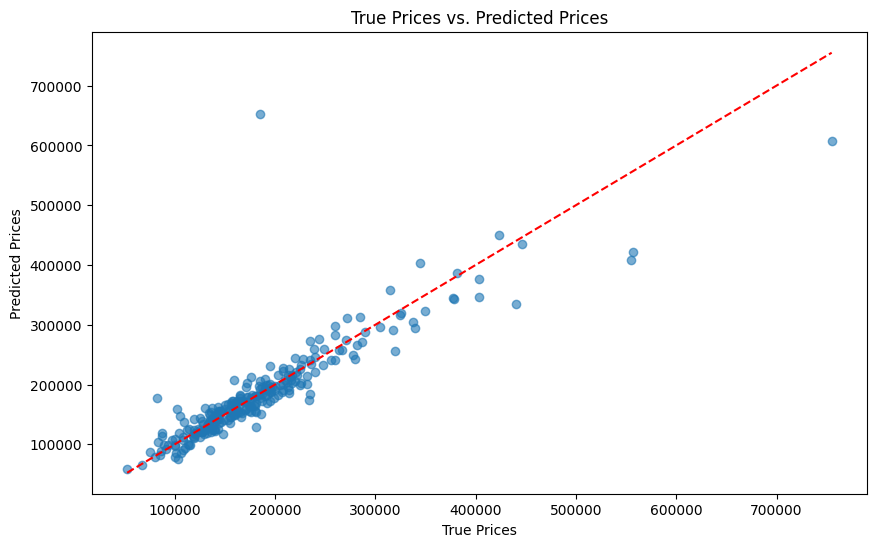

In [47]:
import matplotlib.pyplot as plt

# Load the best checkpoint model
best_model = DeepRegressionWithEmbeddings.load_from_checkpoint(f"PS2Q3/{folder_name}/best-checkpoint.ckpt")

# Make predictions on the validation data
predictions = trainer.predict(best_model, dataloaders=valid_loader)
predictions = torch.cat(predictions).detach().numpy()

# Transform the predictions and true prices back to the original price scale
predictions_original_scale = price_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
true_prices_original_scale = price_scaler.inverse_transform(val_df['SalePrice'].values.reshape(-1, 1)).flatten()

# Plot the true prices against the predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(true_prices_original_scale, predictions_original_scale, alpha=0.6)
plt.plot([true_prices_original_scale.min(), true_prices_original_scale.max()],
         [true_prices_original_scale.min(), true_prices_original_scale.max()], 'r--')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True Prices vs. Predicted Prices')
plt.show()

Amazingly, we never had to represent 450 features!  The embeddings layer did all of the work!

## Part 1 (and only)

Using everything you've learned about regression, embeddings, neural networks, generalization, etc., train a differentiable model using PyTorch that will do a good job of **robustly** predicting the price of the homes that are included in the held out test data set.

My advice is to start with basic linear regression, then play around with hidden layers.  Finally, I would explore heteroskedastic regression models as well as stochastic volatility models.  You can see an example of this in 13.2.4.4 of PML1.

I will judge your predictions using an automated checker that can be found at XXX.  Submit your predictions in the requested form.  You may submit as many models as you would like to be judged.

Your predictions will be judged using a specific loss function that is not MSE.  The loss function will be symmetric around zero and will penalize rare big misses less harshly than a lot of small misses.  As such, you'll want to play around with different loss functions included in `torch.nn` to find a model that seems to perform well for the validation data set.

When creating predictions for the test data set, be aware that there is an additional ID column that should be used to identify your predictions for the checker.  Be sure not to accidentally include this column when you make your predictions.

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, Dataset

# ------------------------------
# 1. Load the Data
# ------------------------------
# Adjust the file paths as needed.
train_df = pd.read_csv("/Users/nicholasrichards/Desktop/machine_learning_2/ProblemSet2/house_train.csv")
val_df = pd.read_csv("/Users/nicholasrichards/Desktop/machine_learning_2/ProblemSet2/house_valid.csv")
# For the test set, note that it may not have the target column ("SalePrice")
test_df = pd.read_csv("/Users/nicholasrichards/Desktop/machine_learning_2/ProblemSet2/house_test_noval.csv")  

# ------------------------------
# 2. Identify Continuous and Categorical Features
# ------------------------------
# Continuous features: any column whose name includes "area", "sf", "porch", or "saleprice"
continuous_cols = [col for col in train_df.columns if any(sub in col.lower() for sub in ["area", "sf", "porch", "saleprice"])]

# The target is SalePrice; remove it from continuous features.
if 'SalePrice' in continuous_cols:
    continuous_cols.remove('SalePrice')

# All other columns (except the target) are considered categorical.
categorical_cols = [col for col in train_df.columns if col not in continuous_cols and col != "SalePrice"]

print("Continuous columns:", continuous_cols)
print("Number of continuous columns:", len(continuous_cols))
print("Categorical columns:", categorical_cols)
print("Number of categorical columns:", len(categorical_cols))

# For additional insight, print the number of distinct values for each categorical feature.
distinct_values = {col: train_df[col].nunique() for col in categorical_cols}
print("Distinct values per categorical variable:")
print(distinct_values)

# ------------------------------
# 3. Data Preprocessing: Standardization and Encoding
# ------------------------------
# Standardize continuous features.
scaler = StandardScaler()
train_df[continuous_cols] = scaler.fit_transform(train_df[continuous_cols])
val_df[continuous_cols] = scaler.transform(val_df[continuous_cols])
test_df[continuous_cols] = scaler.transform(test_df[continuous_cols])

# Scale the target variable (SalePrice) separately.
price_scaler = StandardScaler()
train_df['SalePrice'] = price_scaler.fit_transform(train_df[['SalePrice']])
val_df['SalePrice'] = price_scaler.transform(val_df[['SalePrice']])
# The test set does not have a target.

# Encode categorical variables using LabelEncoder.
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    val_df[col] = le.transform(val_df[col])
    test_df[col] = le.transform(test_df[col])
    encoders[col] = le

# Optionally, view a few rows of the processed data.
print("Processed training data:")
print(train_df.head())
print("Processed validation data:")
print(val_df.head())
print("Processed test data:")
print(test_df.head())

# ------------------------------
# 4. Create a Custom Dataset for PyTorch
# ------------------------------
# We want our dataset to yield three items:
#   - continuous features (float tensor)
#   - categorical features (long tensor)
#   - target (float tensor) for train/val; test data may not have a target.
class CustomDataset(Dataset):
    def __init__(self, df, continuous_cols, categorical_cols, target_col=None):
        self.continuous = torch.tensor(df[continuous_cols].values, dtype=torch.float32)
        self.categorical = torch.tensor(df[categorical_cols].values, dtype=torch.long)
        if target_col is not None and target_col in df.columns:
            self.target = torch.tensor(df[target_col].values, dtype=torch.float32)
        else:
            self.target = None

    def __len__(self):
        return len(self.continuous)

    def __getitem__(self, idx):
        if self.target is not None:
            return self.continuous[idx], self.categorical[idx], self.target[idx]
        else:
            return self.continuous[idx], self.categorical[idx]

# Create dataset objects.
train_dataset = CustomDataset(train_df, continuous_cols, categorical_cols, target_col='SalePrice')
val_dataset = CustomDataset(val_df, continuous_cols, categorical_cols, target_col='SalePrice')
# For test data, omit the target.
test_dataset = CustomDataset(test_df, continuous_cols, categorical_cols)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# For testing, use the full set or an appropriate batch size.
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Continuous columns: ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
Number of continuous columns: 17
Categorical columns: ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'PavedDrive', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Number of categorical columns: 46
Distinct values per categoric

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming train_loader, val_loader, and test_loader are already defined from your custom dataset
# and that continuous_cols and categorical_cols are defined as in your preprocessing step.

# Compute the number of unique categories for each categorical column
num_categories = [train_df[col].nunique() for col in categorical_cols]
# For our basic linear model, we use a 1-dimensional embedding for each categorical feature.
embedding_dims = [1] * len(num_categories)

# Define the basic linear regression model with embeddings
class BasicLinearRegressionWithEmbeddings(nn.Module):
    def __init__(self, num_continuous, num_categories, embedding_dims):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): List of unique counts for each categorical feature.
            embedding_dims (list of int): List of embedding dimensions for each categorical feature.
        """
        super(BasicLinearRegressionWithEmbeddings, self).__init__()
        # Create an embedding layer for each categorical feature.
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories[i], embedding_dims[i]) for i in range(len(num_categories))
        ])
        # Total embedding dimension (sum over all categorical features)
        total_embedding_dim = sum(embedding_dims)
        # The input dimension for the final linear layer
        input_dim = num_continuous + total_embedding_dim
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, continuous, categorical):
        # Process each categorical feature with its embedding layer.
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        # Each embedded output has shape [batch_size, embedding_dim]; concatenate along dimension 1.
        embedded = torch.cat(embedded, dim=1)
        # Concatenate continuous features with the embedded categorical features.
        x = torch.cat([continuous, embedded], dim=1)
        # Compute the linear output.
        out = self.linear(x)
        return out.squeeze(1)  # Squeeze to return a 1D tensor of predictions.

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the model.
model = BasicLinearRegressionWithEmbeddings(
    num_continuous=len(continuous_cols),
    num_categories=num_categories,
    embedding_dims=embedding_dims
).to(device)

# Define loss function and optimizer.
criterion = nn.MSELoss()  # Baseline loss; later you can experiment with others.
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop.
num_epochs = 100  # You can adjust this as needed.
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
        # Each batch is a tuple: (continuous, categorical, target)
        continuous, categorical, target = batch
        continuous = continuous.to(device)
        categorical = categorical.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        predictions = model(continuous, categorical)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_train_loss = sum(train_losses) / len(train_losses)
    
    # Evaluate on the validation set.
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            continuous, categorical, target = batch
            continuous = continuous.to(device)
            categorical = categorical.to(device)
            target = target.to(device)
            predictions = model(continuous, categorical)
            loss = criterion(predictions, target)
            val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/100 - Train Loss: 1.1594, Val Loss: 0.7715
Epoch 2/100 - Train Loss: 0.4687, Val Loss: 0.4584
Epoch 3/100 - Train Loss: 0.3313, Val Loss: 0.3662
Epoch 4/100 - Train Loss: 0.2874, Val Loss: 0.3264
Epoch 5/100 - Train Loss: 0.2582, Val Loss: 0.3203
Epoch 6/100 - Train Loss: 0.2456, Val Loss: 0.2937
Epoch 7/100 - Train Loss: 0.2288, Val Loss: 0.2834
Epoch 8/100 - Train Loss: 0.2180, Val Loss: 0.2766
Epoch 9/100 - Train Loss: 0.2127, Val Loss: 0.2698
Epoch 10/100 - Train Loss: 0.2001, Val Loss: 0.2669
Epoch 11/100 - Train Loss: 0.1957, Val Loss: 0.2620
Epoch 12/100 - Train Loss: 0.1926, Val Loss: 0.2614
Epoch 13/100 - Train Loss: 0.1832, Val Loss: 0.2614
Epoch 14/100 - Train Loss: 0.1828, Val Loss: 0.2615
Epoch 15/100 - Train Loss: 0.1760, Val Loss: 0.2594
Epoch 16/100 - Train Loss: 0.1748, Val Loss: 0.2596
Epoch 17/100 - Train Loss: 0.1807, Val Loss: 0.2606
Epoch 18/100 - Train Loss: 0.1700, Val Loss: 0.2605
Epoch 19/100 - Train Loss: 0.1728, Val Loss: 0.2570
Epoch 20/100 - Train 

In [50]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

# ------------------------------
# Your original basic model definition
# ------------------------------
class BasicLinearRegressionWithEmbeddings(nn.Module):
    def __init__(self, num_continuous, num_categories, embedding_dims):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): List of unique counts for each categorical feature.
            embedding_dims (list of int): List of embedding dimensions for each categorical feature.
        """
        super(BasicLinearRegressionWithEmbeddings, self).__init__()
        # Create an embedding layer for each categorical feature.
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories[i], embedding_dims[i]) for i in range(len(num_categories))
        ])
        # Total embedding dimension (sum over all categorical features)
        total_embedding_dim = sum(embedding_dims)
        # The input dimension for the final linear layer is continuous features plus embeddings.
        input_dim = num_continuous + total_embedding_dim
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, continuous, categorical):
        # Process each categorical feature with its embedding layer.
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        # Concatenate all embeddings (each of shape [batch_size, embedding_dim]).
        embedded = torch.cat(embedded, dim=1)
        # Concatenate continuous features with the embeddings.
        x = torch.cat([continuous, embedded], dim=1)
        # Compute the linear output.
        out = self.linear(x)
        return out.squeeze(1)  # Return a 1D tensor of predictions.

# ------------------------------
# Convert the above model into a Lightning Module
# ------------------------------
class BasicLinearRegressionLightning(pl.LightningModule):
    def __init__(self, num_continuous, num_categories, embedding_dims, learning_rate=1e-3):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): List of unique counts for each categorical feature.
            embedding_dims (list of int): List of embedding dimensions for each categorical feature.
            learning_rate (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()  # Saves all arguments to self.hparams
        self.model = BasicLinearRegressionWithEmbeddings(
            num_continuous=num_continuous,
            num_categories=num_categories,
            embedding_dims=embedding_dims
        )
        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate

    def forward(self, continuous, categorical):
        return self.model(continuous, categorical)
    
    def training_step(self, batch, batch_idx):
        # Expecting batch as a tuple: (continuous, categorical, target)
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss = self.criterion(preds, target)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss = self.criterion(preds, target)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    '''
    def test_step(self, batch, batch_idx):
        # Try to unpack three values; if that fails, unpack two.
        try:
            continuous, categorical, target = batch
        except ValueError:
            continuous, categorical = batch
        preds = self(continuous, categorical)
        # Optionally log loss if target is present.
        try:
            loss = self.criterion(preds, target)
            self.log("test_loss", loss, on_step=False, on_epoch=True)
        except NameError:
            pass  # No target provided in the test batch.
        return preds
    '''
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# ------------------------------
# Usage example (assuming your DataLoaders and feature lists are defined)
# ------------------------------
# Compute the number of unique categories for each categorical column
num_categories = [train_df[col].nunique() for col in categorical_cols]
# For our basic model, we use a 1-dimensional embedding for each categorical feature.
embedding_dims = [1] * len(num_categories)

# Instantiate the Lightning model.
model_lightning = BasicLinearRegressionLightning(
    num_continuous=len(continuous_cols),
    num_categories=num_categories,
    embedding_dims=embedding_dims,
    learning_rate=0.001  # or any other value you'd like to use
)

# Now you can pass this model to a PyTorch Lightning Trainer:
trainer = pl.Trainer(max_epochs=100, accelerator='auto', devices='auto')
trainer.fit(model_lightning, train_dataloaders=train_loader, val_dataloaders=valid_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | BasicLinearRegressionWithEmbeddings | 547    | train
1 | criterion | MSELoss                             | 0      | train
--------------------------------------------------------------------------
547       Trainable params
0         Non-trainable params
547       Total params
0.002     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the tr

Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 28.93it/s, v_num=1, val_loss=0.250, train_loss=0.138]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 27.11it/s, v_num=1, val_loss=0.250, train_loss=0.138]


In [51]:
sample = test_dataset[0]
print(len(sample))  # Should print 2


2


In [52]:
import pandas as pd
import torch

# --- Step 1: Extract IDs from the original test DataFrame ---
test_ids = test_df["ID"]

# --- Step 2: Prepare the features for prediction ---
test_features = test_df.drop(columns=["ID"])
test_continuous = test_features[continuous_cols].values
test_categorical = test_features[categorical_cols].values

# --- Step 3: Convert features to PyTorch tensors ---
test_continuous_tensor = torch.tensor(test_continuous, dtype=torch.float32)
test_categorical_tensor = torch.tensor(test_categorical, dtype=torch.long)

# --- Step 4: Run predictions ---
# Ensure your trained model is loaded as model_lightning.
model_lightning.eval()
with torch.no_grad():
    preds = model_lightning(test_continuous_tensor.to(model_lightning.device),
                            test_categorical_tensor.to(model_lightning.device))
    preds = preds.cpu().numpy()

# --- Step 5: Inverse-transform the predictions ---
# Assuming price_scaler was fitted on the training targets (SalePrice)
# The scaler expects a 2D array, so we reshape and then squeeze after inverse transform.
preds_unscaled = price_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()

# --- Step 6: Create output DataFrame ---
output_df = pd.DataFrame({
    "ID": test_ids,
    "Prediction": preds_unscaled
})

# Format predictions to 4 decimal places (if desired).
output_df["Prediction"] = output_df["Prediction"].apply(lambda x: f"{x:.4f}")

# --- Step 7: Save the DataFrame to a CSV file ---
output_df.to_csv("basic_reg_preds.csv", index=False)
print("Predictions saved to basic_reg_preds.csv")





Predictions saved to basic_reg_preds.csv


In [53]:
with torch.no_grad():
    # For heteroskedastic models, the output shape is [N, 2] (mean and log variance).
    # We take the first output (the predicted mean) as the prediction.
    preds = model_lightning(test_continuous_tensor.to(model_lightning.device),
                            test_categorical_tensor.to(model_lightning.device))
    if preds.ndim == 2 and preds.shape[1] == 2:
        preds = preds[:, 0]
    preds = preds.cpu().numpy()

Now we are implementing hidden layers which builds on our linear regression model.

In [54]:

# Define the deep regression model with embeddings and hidden layers.
class DeepRegressionWithEmbeddings(nn.Module):
    def __init__(self, num_continuous, num_categories, embedding_dims, hidden_units=[128, 64]):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): Unique category counts for each categorical variable.
            embedding_dims (list of int): Embedding dimensions for each categorical variable.
            hidden_units (list of int): List specifying the number of units in each hidden layer.
        """
        super(DeepRegressionWithEmbeddings, self).__init__()
        # Create embedding layers for each categorical feature.
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories[i], embedding_dims[i]) for i in range(len(num_categories))
        ])
        total_embedding_dim = sum(embedding_dims)
        # The input dimension is the sum of continuous features and all embeddings.
        input_dim = num_continuous + total_embedding_dim
        
        # Build the hidden layers.
        layers = []
        prev_dim = input_dim
        for units in hidden_units:
            layers.append(nn.Linear(prev_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(units))
            prev_dim = units
        # Final output layer.
        layers.append(nn.Linear(prev_dim, 1))
        
        # Combine layers into a sequential model.
        self.model = nn.Sequential(*layers)
    
    def forward(self, continuous, categorical):
        # Process each categorical feature through its embedding.
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        # Concatenate all embedded categorical features.
        embedded = torch.cat(embedded, dim=1)
        # Concatenate continuous features and embeddings.
        x = torch.cat([continuous, embedded], dim=1)
        # Forward pass through the hidden layers and output layer.
        out = self.model(x)
        return out.squeeze(1)

# Device configuration.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume continuous_cols and categorical_cols have been defined during preprocessing.
# Compute the number of unique categories for each categorical column.
num_categories = [train_df[col].nunique() for col in categorical_cols]
# For this deep model, we still use 1-dimensional embeddings.
embedding_dims = [1] * len(num_categories)

# Instantiate the model.
deep_model = DeepRegressionWithEmbeddings(
    num_continuous=len(continuous_cols),
    num_categories=num_categories,
    embedding_dims=embedding_dims,
    hidden_units=[128, 64]  # You can experiment with different hidden layer sizes.
).to(device)

# Define loss function and optimizer.
criterion = nn.MSELoss()  # Baseline loss; later, you can experiment with alternative loss functions.
optimizer = torch.optim.Adam(deep_model.parameters(), lr=1e-3)

# Training loop.
num_epochs = 100  # Adjust the number of epochs as needed.
for epoch in range(num_epochs):
    deep_model.train()
    train_losses = []
    for batch in train_loader:
        # Each batch: (continuous, categorical, target)
        continuous, categorical, target = batch
        continuous = continuous.to(device)
        categorical = categorical.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        predictions = deep_model(continuous, categorical)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = sum(train_losses) / len(train_losses)
    
    # Evaluate on the validation set.
    deep_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            continuous, categorical, target = batch
            continuous = continuous.to(device)
            categorical = categorical.to(device)
            target = target.to(device)
            preds = deep_model(continuous, categorical)
            loss = criterion(preds, target)
            val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Generate predictions for the test set.
deep_model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        # Test dataset returns only continuous and categorical features.
        continuous, categorical = batch
        continuous = continuous.to(device)
        categorical = categorical.to(device)
        preds = deep_model(continuous, categorical)
        test_predictions.append(preds.cpu().numpy())
test_predictions = np.concatenate(test_predictions)
print("Test set predictions (first 10):", test_predictions[:10])


Epoch 1/100 - Train Loss: 0.5516, Val Loss: 0.6300
Epoch 2/100 - Train Loss: 0.2343, Val Loss: 0.3530
Epoch 3/100 - Train Loss: 0.2118, Val Loss: 0.3158
Epoch 4/100 - Train Loss: 0.1340, Val Loss: 0.3202
Epoch 5/100 - Train Loss: 0.1219, Val Loss: 0.3156
Epoch 6/100 - Train Loss: 0.0947, Val Loss: 0.3113
Epoch 7/100 - Train Loss: 0.0847, Val Loss: 0.3125
Epoch 8/100 - Train Loss: 0.0943, Val Loss: 0.3045
Epoch 9/100 - Train Loss: 0.0898, Val Loss: 0.3216
Epoch 10/100 - Train Loss: 0.0750, Val Loss: 0.3371
Epoch 11/100 - Train Loss: 0.0642, Val Loss: 0.3237
Epoch 12/100 - Train Loss: 0.0560, Val Loss: 0.3176
Epoch 13/100 - Train Loss: 0.0581, Val Loss: 0.3258
Epoch 14/100 - Train Loss: 0.0614, Val Loss: 0.3322
Epoch 15/100 - Train Loss: 0.0505, Val Loss: 0.3261
Epoch 16/100 - Train Loss: 0.0449, Val Loss: 0.3230
Epoch 17/100 - Train Loss: 0.0509, Val Loss: 0.3276
Epoch 18/100 - Train Loss: 0.0671, Val Loss: 0.3231
Epoch 19/100 - Train Loss: 0.0481, Val Loss: 0.3293
Epoch 20/100 - Train 

We observe lots of overfitting in this deep linear regression model, so we will start trying out some weight decay and dropout layers.

In [55]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim

# Assume deep_model, train_loader, val_loader, and test_loader have already been defined.
# Also assume device is set to "cuda" if available.

# Define loss function.
criterion = nn.MSELoss()

# Create an optimizer with weight decay for L2 regularization.
optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.01, weight_decay=0.01)

# Early stopping parameters.
patience = 10            # Number of epochs to wait for improvement.
best_val_loss = np.inf  # Initialize best validation loss as infinity.
epochs_without_improvement = 0
best_model_state = None

num_epochs = 50  # Maximum number of epochs

for epoch in range(num_epochs):
    deep_model.train()
    train_losses = []
    for batch in train_loader:
        # Each batch: (continuous, categorical, target)
        continuous, categorical, target = batch
        continuous = continuous.to(device)
        categorical = categorical.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        predictions = deep_model(continuous, categorical)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    # Evaluate on validation set.
    deep_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            continuous, categorical, target = batch
            continuous = continuous.to(device)
            categorical = categorical.to(device)
            target = target.to(device)
            preds = deep_model(continuous, categorical)
            loss = criterion(preds, target)
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    
    # Check for improvement.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_state = deep_model.state_dict()
        print("  New best model found!")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement for {epochs_without_improvement} epochs.")
    
    # Trigger early stopping if no improvement for 'patience' epochs.
    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

# Restore the best model state.
if best_model_state is not None:
    deep_model.load_state_dict(best_model_state)
    print(f"Restored best model with validation loss {best_val_loss:.4f}")

# Generate predictions on the test set.
deep_model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        # Test dataset yields only continuous and categorical features.
        continuous, categorical = batch
        continuous = continuous.to(device)
        categorical = categorical.to(device)
        preds = deep_model(continuous, categorical)
        test_predictions.append(preds.cpu().numpy())
test_predictions = np.concatenate(test_predictions)
print("Test set predictions (first 10):", test_predictions[:10])


Epoch 1/50 - Train Loss: 0.2958 - Val Loss: 0.3714
  New best model found!
Epoch 2/50 - Train Loss: 0.2538 - Val Loss: 0.3933
  No improvement for 1 epochs.
Epoch 3/50 - Train Loss: 0.2089 - Val Loss: 0.2763
  New best model found!
Epoch 4/50 - Train Loss: 0.1753 - Val Loss: 0.3226
  No improvement for 1 epochs.
Epoch 5/50 - Train Loss: 0.1633 - Val Loss: 0.3834
  No improvement for 2 epochs.
Epoch 6/50 - Train Loss: 0.2232 - Val Loss: 0.4471
  No improvement for 3 epochs.
Epoch 7/50 - Train Loss: 0.2016 - Val Loss: 0.3230
  No improvement for 4 epochs.
Epoch 8/50 - Train Loss: 0.1772 - Val Loss: 0.3389
  No improvement for 5 epochs.
Epoch 9/50 - Train Loss: 0.1471 - Val Loss: 0.3566
  No improvement for 6 epochs.
Epoch 10/50 - Train Loss: 0.1374 - Val Loss: 0.4336
  No improvement for 7 epochs.
Epoch 11/50 - Train Loss: 0.1959 - Val Loss: 0.3020
  No improvement for 8 epochs.
Epoch 12/50 - Train Loss: 0.2006 - Val Loss: 0.3020
  No improvement for 9 epochs.
Epoch 13/50 - Train Loss: 0

We decided to focus on Huber loss for this problem because it is symmetric around zero, meaning that it treats positive and negative values equally, and weights larger variations from the mean less than more closer ones. This is ideal for analyzing our test data.

In [56]:
import pytorch_lightning as pl

class HyperparameterLogger(pl.Callback):
    def on_train_start(self, trainer, pl_module):
        # Create a dictionary with the hyperparameters you want to log.
        hparams = pl_module.hparams
        # For example, assume you want to log learning_rate, weight_decay, and hidden_units.
        metrics = {
            "learning_rate": hparams.learning_rate,
            "weight_decay": hparams.weight_decay if hasattr(hparams, "weight_decay") else None,
            "hidden_units": str(getattr(hparams, "hidden_units", "N/A"))
        }
        # Log these metrics at step 0. They will appear in your CSV log.
        trainer.logger.log_metrics(metrics, step=0)


After experimenting with many different variations with our hyperparamters of our deep regression model, we found using a learning rate of 0.05, weight decay of 0.0005, two hidden layers with values 512 and 256, and early stopping with patience of 10 epochs. These parameters allowed us to minimize Huber loss while maintaining relatively low values for MSE and MAE loss. We ended up using 50 epochs as this helped us run our code more efficiently and seemed to eliminate any overfitting.

In [57]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


# -----------------------------------------------------------------------------
# Define the Lightning Module that wraps the deep regression model.
# -----------------------------------------------------------------------------
class DeepRegressionLightning(pl.LightningModule):
    def __init__(self, num_continuous, num_categories, embedding_dims, learning_rate=0.05):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): Unique counts for each categorical feature.
            embedding_dims (list of int): Embedding dimensions for each categorical feature.
            learning_rate (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()  # This will save num_continuous, num_categories, embedding_dims, and learning_rate

        # Instantiate your deep regression model.
        # Here we use a two-hidden-layer architecture as an example.
        self.model = DeepRegressionWithEmbeddings(
            num_continuous=num_continuous,
            num_categories=num_categories,
            embedding_dims=embedding_dims,
            hidden_units=[512, 256]
        )
        self.learning_rate = learning_rate
        
        # Define multiple loss functions.
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
        self.huber_loss = nn.SmoothL1Loss()  # Huber Loss
        
    def forward(self, continuous, categorical):
        return self.model(continuous, categorical)
    
    def training_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss_mse = self.mse_loss(preds, target)
        loss_mae = self.mae_loss(preds, target)
        loss_huber = self.huber_loss(preds, target)
        
        # Log the three loss metrics for training.
        self.log("train_loss_mse", loss_mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_loss_mae", loss_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_loss_huber", loss_huber, on_step=False, on_epoch=True, prog_bar=True)
        
        # Use MSE as the main loss to backpropagate.
        return loss_huber
    
    def validation_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss_mse = self.mse_loss(preds, target)
        loss_mae = self.mae_loss(preds, target)
        loss_huber = self.huber_loss(preds, target)
        
        # Log the validation metrics.
        self.log("val_loss_mse", loss_mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_loss_mae", loss_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_loss_huber", loss_huber, on_step=False, on_epoch=True, prog_bar=True)
        return loss_huber
    
    def test_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss_mse = self.mse_loss(preds, target)
        self.log("test_loss_mse", loss_mse, on_step=False, on_epoch=True)
        return loss_huber
    
    def configure_optimizers(self):
        # Using weight decay (L2 regularization) as well.
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.0005)
        return optimizer

# -----------------------------------------------------------------------------
# CSVLogger, ModelCheckpoint, and RichProgressBar Setup
# -----------------------------------------------------------------------------
folder_name = "Model5"

# CSVLogger will save logs in "PS2Q3/Model1".
logger = CSVLogger("PS2Q3", name=folder_name, flush_logs_every_n_steps=1, version="")

# Save the best model (lowest validation MSE) in the same folder.
checkpoint_callback = ModelCheckpoint(
    dirpath=f"PS2Q3/{folder_name}",
    filename="best-checkpoint",
    monitor="val_loss_huber",
    mode="min"
)

# RichProgressBar gives a nicer progress bar.
rich_bar = RichProgressBar()

# Instantiate your custom hyperparameter logger callback.
hp_logger = HyperparameterLogger()

early_stopping = EarlyStopping(
    monitor="val_loss_huber",
    patience=10,
    min_delta=0.005,
    mode="min",
    verbose=True
)

# -----------------------------------------------------------------------------
# Model Instantiation and Trainer Setup
# -----------------------------------------------------------------------------
# Assume:
#   - continuous_cols is the list of continuous feature names.
#   - categorical_cols is the list of categorical feature names.
#   - train_df, valid_df, etc. are your preprocessed DataFrames.
#   - num_categories: a list with the number of unique categories for each categorical feature.
#   - embedding_dims: here we use 1-dimensional embeddings for simplicity.
num_categories = [train_df[col].nunique() for col in categorical_cols]
embedding_dims = [1] * len(num_categories)

# Instantiate the Lightning model.
tuned_deep_model_lightning = DeepRegressionLightning(
    num_continuous=len(continuous_cols),
    num_categories=num_categories,
    embedding_dims=embedding_dims,
    learning_rate=0.05
)

# Instantiate the PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices='auto',
    logger=logger,
    callbacks=[checkpoint_callback, rich_bar, hp_logger]
)

# Start training by passing in your DataLoaders.
trainer.fit(tuned_deep_model_lightning, train_dataloaders=train_loader, val_dataloaders=valid_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ DeepRegressionWithEmbeddings │  166 K │ train │
│ 1 │ mse_loss   │ MSELoss                      │      0 │ train │
│ 2 │ mae_loss   │ L1Loss                       │      0 │ train │
│ 3 │ huber_loss │ SmoothL1Loss                 │      0 │ train │
└───┴────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 166 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 166 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 59                                                                                          
Modules in eval mode: 0

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/co
nnectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/co
nnectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve 
performance.

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/loops/fit_
loop.py:298: The number of training batches (15) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

`Trainer.fit` stopped: `max_epochs=50` reached.


In [58]:
# --- Step 4: Run predictions using your trained model ---
# Make sure your DeepRegressionLightning model (here referred to as model_lightning)
# is the trained model. For inference, set the model to evaluation mode.
tuned_deep_model_lightning.eval()
with torch.no_grad():
    preds = tuned_deep_model_lightning(
        test_continuous_tensor.to(model_lightning.device),
        test_categorical_tensor.to(model_lightning.device)
    )
    preds = preds.cpu().numpy()  # Convert predictions to a NumPy array

# --- Optional Step: Inverse transform predictions if you scaled your target ---
# If you used a scaler (e.g., price_scaler) to scale SalePrice during training, apply it here:
preds = price_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()

# --- Step 5: Format the predictions into the required CSV format ---
output_df = pd.DataFrame({
    "ID": test_ids,
    "Prediction": preds
})

# Optionally, format the predictions to 4 decimal places.
output_df["Prediction"] = output_df["Prediction"].apply(lambda x: f"{x:.4f}")

# --- Step 6: Save the predictions to a CSV file ---
output_df.to_csv("tuned_deep_reg_preds.csv", index=False)
print("Predictions saved to tuned_deep_reg_preds.csv")

Predictions saved to tuned_deep_reg_preds.csv


In [59]:
import torch
import torch.nn as nn

class HeteroskedasticDeepRegressionWithEmbeddings(nn.Module):
    def __init__(self, num_continuous, num_categories, embedding_dims, hidden_units):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): Unique counts for each categorical feature.
            embedding_dims (list of int): Embedding dimensions for each categorical feature.
            hidden_units (list of int): List of units for each hidden layer.
        """
        super().__init__()
        # Create embedding layers for each categorical feature.
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories[i], embedding_dims[i]) for i in range(len(num_categories))
        ])
        total_embedding_dim = sum(embedding_dims)
        # Input dimension: continuous features + all embedding dimensions.
        input_dim = num_continuous + total_embedding_dim
        
        layers = []
        prev_dim = input_dim
        for units in hidden_units:
            layers.append(nn.Linear(prev_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(units))
            prev_dim = units
        # Final layer outputs 2 values: [mean, log_variance]
        layers.append(nn.Linear(prev_dim, 2))
        self.model = nn.Sequential(*layers)
    
    def forward(self, continuous, categorical):
        # Get embeddings for each categorical feature.
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        # Concatenate continuous features with the embeddings.
        x = torch.cat([continuous, embedded], dim=1)
        out = self.model(x)  # out shape: [batch_size, 2]
        return out


In [60]:
import pytorch_lightning as pl

class HeteroskedasticRegressionLightning(pl.LightningModule):
    def __init__(self, num_continuous, num_categories, embedding_dims, learning_rate=0.05):
        """
        Args:
            num_continuous (int): Number of continuous features.
            num_categories (list of int): Unique counts for each categorical feature.
            embedding_dims (list of int): Embedding dimensions for each categorical feature.
            learning_rate (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters for logging.
        
        # Instantiate the heteroskedastic model.
        self.model = HeteroskedasticDeepRegressionWithEmbeddings(
            num_continuous=num_continuous,
            num_categories=num_categories,
            embedding_dims=embedding_dims,
            hidden_units=[128,64]  # You can adjust the architecture here.
        )
        self.learning_rate = learning_rate

    def forward(self, continuous, categorical):
        # Returns two outputs per instance: [mu, log_variance]
        return self.model(continuous, categorical)
    
    def heteroskedastic_loss(self, preds, target):
        # preds is of shape [batch_size, 2]. Split into mu and s (log variance).
        mu = preds[:, 0]
        s = preds[:, 1]
        # Compute the loss as: 0.5 * exp(-s) * (target - mu)^2 + 0.5 * s
        loss = 0.5 * torch.exp(-s) * (target - mu) ** 2 + 0.5 * s
        return loss.mean()
    
    def training_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss = self.heteroskedastic_loss(preds, target)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss = self.heteroskedastic_loss(preds, target)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        continuous, categorical, target = batch
        preds = self(continuous, categorical)
        loss = self.heteroskedastic_loss(preds, target)
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.0000)
        return optimizer


In [61]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar, EarlyStopping

folder_name = "HeteroModel1"

# CSVLogger: logs will be saved in "PS2Q3/HeteroModel1"
logger = CSVLogger("PS2Q3", name=folder_name, flush_logs_every_n_steps=1, version="")

# ModelCheckpoint: Monitor the validation heteroskedastic loss.
checkpoint_callback = ModelCheckpoint(
    dirpath=f"PS2Q3/{folder_name}",
    filename="best-checkpoint",
    monitor="val_loss",
    mode="min"
)

rich_bar = RichProgressBar()

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=15,
    mode="min",
    verbose=True
)

# (Optional) If you have a hyperparameter logging callback, include it.
hp_logger = HyperparameterLogger() 

# Instantiate the Lightning model.
# Assume continuous_cols and categorical_cols are defined; num_categories and embedding_dims computed as before.
num_categories = [train_df[col].nunique() for col in categorical_cols]
embedding_dims = [1] * len(num_categories)

hetero_deep_lightning = HeteroskedasticRegressionLightning(
    num_continuous=len(continuous_cols),
    num_categories=num_categories,
    embedding_dims=embedding_dims,
    learning_rate=0.01
)

# Instantiate the Trainer.
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='auto',
    devices='auto',
    logger=logger,
    callbacks=[checkpoint_callback, rich_bar, early_stopping, hp_logger]
)

# Start training by passing in your DataLoaders.
trainer.fit(hetero_deep_lightning, train_dataloaders=train_loader, val_dataloaders=valid_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type                                        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ HeteroskedasticDeepRegressionWithEmbeddings │ 17.4 K │ train │
└───┴───────┴─────────────────────────────────────────────┴────────┴───────┘

Trainable params: 17.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 17.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/co
nnectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/trainer/co
nnectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve 
performance.

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/pytorch_lightning/loops/fit_
loop.py:298: The number of training batches (15) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

Metric val_loss improved. New best score: 0.076
Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: -0.331
Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: -0.620
Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: -0.772
Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: -0.785
Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: -0.796
Monitored metric val_loss did not improve in the last 15 records. Best score: -0.796. Signaling Trainer to stop.


Our heteroskedactic model prefers a shallower network with moderate hidden values of 128 and 64, no weight decay, a relatively large early stopping patience of 15, and an average learning rate of 
0.01.

In [62]:
import pandas as pd
import torch

# --- Step 1: Extract IDs from the original test DataFrame ---
test_ids = test_df["ID"]

# --- Step 2: Prepare the features for prediction ---
test_features = test_df.drop(columns=["ID"])
test_continuous = test_features[continuous_cols].values
test_categorical = test_features[categorical_cols].values

# --- Step 3: Convert features to PyTorch tensors ---
test_continuous_tensor = torch.tensor(test_continuous, dtype=torch.float32)
test_categorical_tensor = torch.tensor(test_categorical, dtype=torch.long)

# --- Step 4: Run predictions using your trained heteroskedastic model ---
hetero_deep_lightning.eval()
with torch.no_grad():
    preds = hetero_deep_lightning(
        test_continuous_tensor.to(hetero_deep_lightning.device),
        test_categorical_tensor.to(hetero_deep_lightning.device)
    )
    preds = preds.cpu().numpy()  # preds shape is (N, 2)

# --- Step 5: Extract the predicted mean (first column) only ---
preds_mean = preds[:, 0]

# --- Step 6: Inverse-scale the predictions ---
# Assuming price_scaler was fitted on the training target.
preds_unscaled = price_scaler.inverse_transform(preds_mean.reshape(-1, 1)).squeeze()

# --- Step 7: Format the predictions into the required CSV format ---
output_df = pd.DataFrame({
    "ID": test_ids,
    "Prediction": preds_unscaled
})

# Format predictions to 4 decimal places.
output_df["Prediction"] = output_df["Prediction"].apply(lambda x: f"{x:.4f}")

# --- Step 8: Save the predictions to a CSV file ---
output_df.to_csv("hetero_deep_preds.csv", index=False)
print("Predictions saved to hetero_deep_preds.csv")


Predictions saved to hetero_deep_preds.csv


In [63]:
print("Test DF shape:", test_df.shape)
print("ID column shape:", test_df["ID"].shape)
print("Features shape after dropping ID:", test_df.drop(columns=["ID"]).shape)




Test DF shape: (254, 64)
ID column shape: (254,)
Features shape after dropping ID: (254, 63)


In [64]:


# --- Step 7: Create output DataFrame in the required format ---
output_df = pd.DataFrame({
    "ID": test_ids,
    "Prediction": preds_unscaled
})

# Format predictions to 4 decimal places.
output_df["Prediction"] = output_df["Prediction"].apply(lambda x: f"{x:.4f}")

# --- Step 8: Save the DataFrame to a CSV file ---
output_df.to_csv("hetero_deep_preds.csv", index=False)
print("Predictions saved to hetero_deep_preds.csv")


Predictions saved to hetero_deep_preds.csv


In [65]:
import pandas as pd
import torch

# --- Debug: Check shapes of test DataFrame ---
print("test_df shape:", test_df.shape)
print("ID column shape:", test_df["ID"].shape)
print("Features shape after dropping ID:", test_df.drop(columns=["ID"]).shape)

# --- Step 1: Extract IDs from the original test DataFrame ---
# Attempt to extract IDs.
test_ids = test_df["ID"]

# --- Step 2: Prepare features for prediction ---
# Drop the "ID" column.
test_features = test_df.drop(columns=["ID"])

# If there's a mismatch in the number of IDs and rows in features, use the DataFrame's index.
if len(test_ids) != len(test_features):
    print("Mismatch detected: using features index as IDs.")
    test_ids = test_features.index

# --- Step 3: Extract continuous and categorical features ---
test_continuous = test_features[continuous_cols].values
test_categorical = test_features[categorical_cols].values

# --- Step 4: Convert features to tensors ---
test_continuous_tensor = torch.tensor(test_continuous, dtype=torch.float32)
test_categorical_tensor = torch.tensor(test_categorical, dtype=torch.long)

# --- Step 5: Run predictions using your trained model ---
hetero_deep_lightning.eval()
with torch.no_grad():
    preds = hetero_deep_lightning(
        test_continuous_tensor.to(hetero_deep_lightning.device),
        test_categorical_tensor.to(hetero_deep_lightning.device)
    )
    preds = preds.cpu().numpy()

# --- Step 6: Inverse-scale the predictions ---
# Assuming price_scaler was used during training.
preds_unscaled = price_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()

test_df shape: (254, 64)
ID column shape: (254,)
Features shape after dropping ID: (254, 63)
